In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.stats import beta as Beta

import os
import sys
root_path = os.path.join(os.path.expanduser('~'), 'bnelearn')
if root_path not in sys.path:
    sys.path.append(root_path)

from bnelearn.experiment.configuration_manager import ConfigurationManager
from bnelearn.util.metrics import ex_interim_utility
from bnelearn.strategy import NeuralNetStrategy
from bnelearn.experiment.equilibria import (
    bne_fpsb_ipv_asymmetric_uniform_overlapping_priors_risk_neutral,
    bne1_kaplan_zhamir, bne2_kaplan_zhamir, bne3_kaplan_zhamir)
from bnelearn.experiment.combinatorial_experiment import LLGFullExperiment

from scripts.utils import colors

BNE envs have been set up.


## 1. Single Item Auctions
### 1.1 Overlapping

/tmp/ipykernel_376787/1237102620.py:21: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax.plot(
/tmp/ipykernel_376787/1237102620.py:21: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax.plot(
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


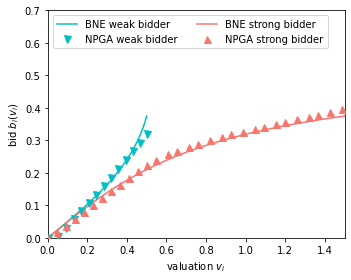

In [17]:
path = '/home/kohring/bnelearn/experiments/asymmmetric-final-results/single_item/first_price/uniform/asymmetric/risk_neutral/2p/2021-11-23 Tue 16.23/models'
n = 100
u_lo = [0., 0.]
u_hi = [.5, 1.5]
valuations = [torch.linspace(u_lo[i], u_hi[i], n).view(-1, 1) for i in range(2)]

fig, ax = plt.subplots(figsize=(5, 4))
bidders = ['weak bidder', 'strong bidder']
markers = ['v', '^']

for agent_idx in range(2):
    action_bne = bne_fpsb_ipv_asymmetric_uniform_overlapping_priors_risk_neutral(
        valuations[agent_idx].view(-1, 1), agent_idx, u_lo, u_hi
    )
    ax.plot(
        valuations[agent_idx], action_bne,
        color=colors[agent_idx], label=f'BNE {bidders[agent_idx]}'
    )
    strat = NeuralNetStrategy.load(f'{path}/model_{agent_idx}.pt')
    action = strat.forward(valuations[agent_idx]).detach().numpy()
    ax.plot(
        valuations[agent_idx], action, '.', markevery=(0, 0.03),
        marker=markers[agent_idx], markersize=7,
        color=colors[agent_idx], label=f'NPGA {bidders[agent_idx]}',
        zorder=10, #clip_on=False
    )

#ax.set_box_aspect(1)
ax.set_xlabel('valuation $v_i$'); ax.set_ylabel('bid $b_{i}(v_i)$')
ax.set_xlim([0, u_hi[1]]); plt.ylim([0, .7])
ax.legend(loc='upper left', ncol=2); plt.tight_layout()
plt.savefig('asym_overlap.eps'); plt.show()

### 1.2 Non-overlapping

/opt/miniconda3/envs/bnelearn/lib/python3.9/site-packages/scipy/optimize/nonlin.py:472: RuntimeWarning: invalid value encountered in double_scalars
  and dx_norm/self.x_rtol <= x_norm))
/tmp/ipykernel_376787/2638045669.py:27: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax.plot(
/tmp/ipykernel_376787/2638045669.py:27: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax.plot(
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


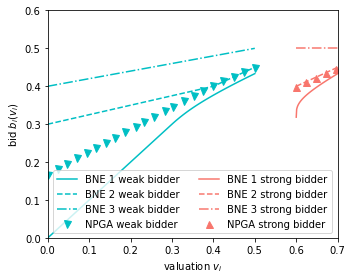

In [19]:
path = '/home/kohring/bnelearn/experiments/asymmmetric-final-results/single_item/first_price/uniform/asymmetric/risk_neutral/2p/2021-11-23 Tue 22.26/models'
n = 100
u_lo = [0, .6]; u_hi = [.5, .7]
valuations = [torch.linspace(u_lo[i], u_hi[i], n).view(-1, 1) for i in range(2)]

_optimal_bids = [
    bne1_kaplan_zhamir(u_lo, u_hi),
    lambda x, y: bne2_kaplan_zhamir(x, y, u_lo, u_hi),
    lambda x, y: bne3_kaplan_zhamir(x, y, u_lo, u_hi)
]

fig, ax = plt.subplots(figsize=(5.0, 4.0))
bidders = ['weak bidder', 'strong bidder']
markers = ['v', '^']

line_styles = ['-', 'dashed', 'dashdot']
for agent_idx in range(2):
    for i, _optimal_bid in enumerate(_optimal_bids):
        action_bne = _optimal_bid(valuations[agent_idx], agent_idx)
        ax.plot(
            valuations[agent_idx], action_bne,
            linestyle=line_styles[i], color=colors[agent_idx],
            label=f'BNE {i+1} {bidders[agent_idx]}'
        )
    strat = NeuralNetStrategy.load(f'{path}/model_{agent_idx}.pt')
    action = strat.forward(valuations[agent_idx]).detach().numpy()
    ax.plot(
        valuations[agent_idx], action, '.', markevery=(0, 0.03),
        marker=markers[agent_idx], markersize=7,
        color=colors[agent_idx], zorder=1, #clip_on=False,
        label=f'NPGA {bidders[agent_idx]}'
    )
        
#ax.set_box_aspect(1)
ax.set_xlabel('valuation $v_i$'); ax.set_ylabel('bid $b_{i}(v_i)$')
ax.set_xlim([0, .7]); plt.ylim([0, .6])
ax.legend(loc='lower left', ncol=2); plt.tight_layout()
plt.savefig('asym_disjoint.eps')
plt.show()

### 1.3 Beta Prior

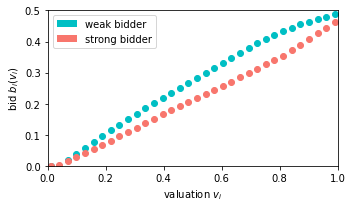

In [75]:
fig, ax = plt.subplots(figsize=(5, 3))

path = '/home/kohring/bnelearn/experiments/asymmmetric-final-results/single_item/first_price/non-common/1.0risk/2players/2021-11-24 Wed 04.57/models'
n = 100
eps = 1e-2
valuations = [torch.linspace(0+eps, 1-eps, n).view(-1, 1) for i in range(2)]

pdfs = [Beta.pdf(valuations[0], 0.8, 1.2), Beta.pdf(valuations[1], 1.2, 0.8)]
pdfs = [(pdfs[0] - pdfs[0].min()) / (pdfs[0].max() - pdfs[0].min()),
        (pdfs[1] - pdfs[1].min()) / (pdfs[1].max() - pdfs[1].min())]

for agent_idx in range(2):
    strat = NeuralNetStrategy.load_old(f'{path}/model_{agent_idx}.pt')
    action = strat.forward(valuations[agent_idx]).detach().numpy()
    n_markers = 3
    ax.scatter(
        valuations[agent_idx][::n_markers], action[::n_markers], #'.--', #markevery=(0, 0.03), markersize=12,
        color=colors[agent_idx], zorder=2, #alpha=pdfs[agent_idx][::n_markers],
    )
ax.bar(-1, -1, label='weak bidder', color=colors[0])
ax.bar(-1, -1, label='strong bidder', color=colors[1])

# ax.plot([0, 1], [0, .5], '--', color='grey')
ax.set_xlabel('valuation $v_i$'); ax.set_ylabel('bid $b_{i}(v_i)$')
#ax.set_box_aspect(1)
ax.set_xlim([0, 1]); ax.set_ylim([0, .5])
ax.legend(loc='upper left')
plt.tight_layout()
plt.savefig('non-common_prior.pdf')
plt.show()

## 2. Asymmetric LLG

/home/kohring/bnelearn/bnelearn/experiment/configuration_manager.py:530: UserWarning: Using fixed valuations for evaluation. This may introduce bias!
  warnings.warn('Using fixed valuations for evaluation. This may introduce bias!')
/home/kohring/bnelearn/bnelearn/sampler/samplers_ipv.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lower_bound = torch.tensor(support.lower_bound).relu()
/home/kohring/bnelearn/bnelearn/sampler/samplers_ipv.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  upper_bound = torch.tensor(support.upper_bound)


Calculating high-precision BNE...


100%|██████████| 2/2 [00:00<00:00, 4715.35it/s]


Calculating high-precision BNE...


100%|██████████| 2/2 [00:00<00:00, 7067.07it/s]


Calculating high-precision BNE...


100%|██████████| 2/2 [00:00<00:00, 6759.56it/s]


Max difference to BNE estimate is 0.154.
Calculating high-precision BNE...


100%|██████████| 100/100 [00:00<00:00, 10509.14it/s]


Calculating high-precision BNE...


100%|██████████| 2/2 [00:00<00:00, 25040.62it/s]


Calculating high-precision BNE...


100%|██████████| 2/2 [00:00<00:00, 7449.92it/s]


Calculating high-precision BNE...


100%|██████████| 2/2 [00:00<00:00, 6904.20it/s]


Max difference to BNE estimate is 0.418.
Calculating high-precision BNE...


100%|██████████| 2/2 [00:00<00:00, 29127.11it/s]


Calculating high-precision BNE...


100%|██████████| 2/2 [00:00<00:00, 6786.90it/s]


Calculating high-precision BNE...


100%|██████████| 2/2 [00:00<00:00, 7423.55it/s]
/tmp/ipykernel_376787/299292905.py:38: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  axs[action_idx].plot(


Max difference to BNE estimate is 0.154.


/tmp/ipykernel_376787/299292905.py:38: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  axs[action_idx].plot(
/tmp/ipykernel_376787/299292905.py:38: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  axs[action_idx].plot(
/tmp/ipykernel_376787/299292905.py:38: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  axs[action_idx].plot(
/tmp/ipykernel_376787/299292905.py:38: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  axs[action_idx].plot(
/tmp/ipykernel_376787/299292905.py:38: UserWarning: marker is redundantly defined by the 'marker' keyword argume

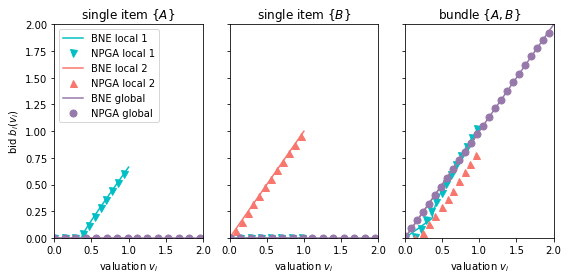

In [3]:
path = '/home/kohring/bnelearn/experiments/asymmmetric-final-results/LLGFull/mrcs_favored/independent/2021-11-24 Wed 11.39/models'
n = 100
u_lo = [0, 0, 0]
u_hi = [1, 1, 2]
valuations = [torch.linspace(u_lo[i], u_hi[i], n).view(-1, 1) for i in range(3)]

fig, axs = plt.subplots(1, 3, figsize=(8, 4), sharey=True)
bidders = ['local 1', 'local 2', 'global']
markers = ['v', '^', 'o']
titles = ['single item $\{A\}$', 'single item $\{B\}$', 'bundle $\{A, B\}$']

action_bnes = [
    LLGFullExperiment(
        ConfigurationManager(experiment_type='llg_full',
            n_runs=0, n_epochs=0,
        ).set_logging(eval_batch_size=2).get_config()[0]) \
    ._optimal_bid(
        valuation=valuations[agent_idx],
        player_position=agent_idx,
    )
    for agent_idx in range(len(bidders))
]
strats = [
    NeuralNetStrategy.load(f'{path}/model_{agent_idx}.pt')
    for agent_idx in range(len(bidders))
]
actions = [
    strat.forward(valuations[agent_idx]).detach().numpy()
    for agent_idx, strat in zip(range(len(bidders)), strats)
]

for action_idx in range(3):
    for agent_idx in range(len(bidders)):
        axs[action_idx].plot(
            valuations[agent_idx], action_bnes[agent_idx][:, action_idx],
            color=colors[agent_idx], label=f'BNE {bidders[agent_idx]}'
        )
        axs[action_idx].plot(
            valuations[agent_idx], actions[agent_idx][:, action_idx], '.',
            markevery=(0, 0.04), markersize=7, marker=markers[agent_idx],
            color=colors[agent_idx],
            label=f'NPGA {bidders[agent_idx]}',
            #zorder=10, #clip_on=False
        )
    axs[action_idx].set_title(titles[action_idx])
    axs[action_idx].set_xlim([0, 2]); axs[action_idx].set_ylim([0, 2])
    axs[action_idx].set_xlabel('valuation $v_i$')

axs[0].set_ylabel('bid $b_{i}(v_i)$')
axs[0].legend(loc='upper left')
plt.tight_layout()
plt.savefig('llgfull_bidfunction.eps')
plt.show()

## 3. Split-Award Auction

In [ ]:
path = ''  # TODO

n = 200
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(8, 4))
v = torch.linspace(u_lo[0], u_hi[0], n)
valuations = torch.zeros((n, 2))
valuations[:, 0] = v
valuations[:, 1] = efficiency_parameter * v

axs[0].plot(-1, 1,  color=colors[0], label='WTA BNE')
axs[0].plot(-1, 1,  '--', color=colors[0], label='pooling BNE')
plot_xmin = [u_lo[0], efficiency_parameter * u_lo[0]]
plot_xmax = [u_hi[0], efficiency_parameter * u_hi[0]]
plot_ymin = [0, 0]
plot_ymax = [2 * u_hi[0], 2 * u_hi[0]]
        
action_bnes = [_optimal_bid()(valuations) for _optimal_bid in _optimal_bids]
strat = NeuralNetStrategy.load('{path}/model.pt')
action = strat.forward(valuations).detach().numpy()
titles = ['50% share', '100% share']
y_labels = ['valuation $C \cdot v_i$', 'valuation $v_i$']

for plot_idx in range(2):
    action_idx = 0 if plot_idx==1 else 1
    
    # BNE 2
    axs[plot_idx].fill_between(
        valuations[:, action_idx],
        action_bnes[0]['sigma_bounds'if plot_idx == 0 else 'wta_bounds'][:, 0],
        action_bnes[0]['sigma_bounds'if plot_idx == 0 else 'wta_bounds'][:, 1],
        color=colors[0],
        alpha=.3
    )
    axs[plot_idx].plot(
        valuations[:, action_idx],
        action_bnes[0]['sigma_bounds'if plot_idx == 0 else 'wta_bounds'][:, 0],
         '--', color=colors[0],
    )
    axs[plot_idx].plot(
        valuations[:, action_idx],
        action_bnes[0]['sigma_bounds'if plot_idx == 0 else 'wta_bounds'][:, 1],
         '--', color=colors[0],
    )

    # BNE 1
    axs[plot_idx].plot(
        valuations[:, action_idx], action_bnes[1][:, action_idx],
        color=colors[0],
    )

    axs[plot_idx].plot(
        valuations[:, action_idx], action[:, action_idx],
        '.', markevery=(0, 0.03),
        markersize=8, label='NPGA',
        color=colors[2],
    )
    axs[plot_idx].set_title(titles[plot_idx])
    axs[plot_idx].set_xlim([plot_xmin[action_idx], plot_xmax[action_idx]])
    axs[plot_idx].set_ylim([plot_ymin[action_idx], plot_ymax[action_idx]])
    axs[plot_idx].set_xlabel(y_labels[plot_idx])
    axs[plot_idx].set_box_aspect(1)
axs[0].set_ylabel('bid $b_{i}(v_i)$')
axs[0].legend(loc='upper left')
#plt.tight_layout()
plt.savefig('split_award.pdf')
plt.show()